In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])
pysim_root = "/home/emmanuel/code/pysim"
# append to path
sys.path.append(str(root))
sys.path.append(str(pysim_root))


import numpy as np

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns

sns.set_context(context="talk", font_scale=0.7)

%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Entropy

In [41]:
from pysim.data.information.gaussian import (
    generate_gaussian_data,
    generate_gaussian_rotation_data,
)
from pysim.data.information.linear import generate_linear_entropy_data
from pysim.information.histogram import hist_entropy
from pysim.information.entropy import marginal_entropy
from functools import partial

In [42]:
n_samples = 50_000
n_features = 2
seed = 123

# create marginal entropy estimator
f = partial(marginal_entropy, estimator=hist_entropy, bins="sqrt", correction=None)

# create seed (trial number)
res_dict = generate_linear_entropy_data(
    n_samples=n_samples,
    n_features=n_features,
    seed=seed,
    marg_h_estimator=f,
    estimator_name="histogram",
    n_base_samples=500_000,
)

res_dict.H

2.3529096902887097

## Demo

### Estimators

In [43]:
from pysim.information.gaussian import gauss_entropy_multi
from pysim.information.knn import knn_entropy, knn_entropy_npeet
import time


def get_entropy_estimators(data):

    t0 = time.time()
    H_g = gauss_entropy_multi(data)
    print(f"Gaussian: {H_g:.4f} | Time: {time.time()-t0:.4f} secs")

    t0 = time.time()
    H_knn_nbs = knn_entropy(X=data, n_neighbors=10, base=2)
    print(f"KNN (Neighbours): {H_knn_nbs:.4f} | Time: {time.time()-t0:.4f} secs")

    t0 = time.time()
    H_knn_eps = knn_entropy_npeet(X=data, n_neighbors=10, base=2)
    print(f"KNN (epsilon): {H_knn_eps:.4f} | Time: {time.time()-t0:.4f} secs")

In [44]:
get_entropy_estimators(res_dict.X.copy())

Gaussian: 3.7915 | Time: 0.0051 secs
KNN (Neighbours): 2.6766 | Time: 0.2744 secs
KNN (epsilon): 2.7663 | Time: 0.2392 secs


## Demo Experiment

In [45]:
n_samples = [500, 1_000, 5_000, 10_000, 50_000]
# n_features = [1, 2, 3, 10, 50, 100]
n_features = [10]
n_trials = 10

In [46]:
from tqdm.notebook import tqdm, trange
import pandas as pd
import itertools
import numpy as np

iteration = itertools.count()


all_stats = pd.DataFrame()


pbar_features = tqdm(n_features, leave=True)

for i_features in pbar_features:

    pbar_features.set_description(f"Features: {i_features}")

    results = {}

    pbar_samples = tqdm(n_samples, leave=False)

    for i_samples in pbar_samples:

        pbar_samples.set_description(f"Samples: {i_samples}")

        pbar_trials = trange(n_trials, leave=False)

        for i_trial in pbar_trials:

            pbar_trials.set_description(f"Trials: {i_trial} | Method: GT")

            # generate data
            res_dict = generate_linear_entropy_data(
                n_samples=i_samples,
                n_features=i_features,
                seed=i_trial,
                marg_h_estimator=f,
                estimator_name="histogram",
                n_base_samples=500_000,
            )
            results = {
                "method": "truth",
                "n_samples": i_samples,
                "n_features": i_features,
                "trial": i_trial,
                "H": res_dict.H,
            }
            all_stats = pd.concat(
                [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
            )

            # ======================
            # Gaussian Estimation
            # ======================
            pbar_trials.set_description(f"Trials: {i_trial} | Method: Gaussian")

            output = gauss_entropy_multi(res_dict.X.copy())
            results = {
                "method": "gaussian",
                "n_samples": i_samples,
                "n_features": i_features,
                "trial": i_trial,
                "H": output,
            }

            all_stats = pd.concat(
                [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
            )

            # ==========================
            # KNN estimated (Neighbors)
            # ==========================

            pbar_trials.set_description(f"Trials: {i_trial} | Method: KNN (Neighbors)")

            output = knn_entropy(X=res_dict.X.copy(), n_neighbors=10, base=2, n_jobs=-1)

            results = {
                "method": "knn_nbs",
                "n_samples": i_samples,
                "n_features": i_features,
                "trial": i_trial,
                "H": output,
            }

            all_stats = pd.concat(
                [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
            )

            # ==========================
            # KNN estimated (Epsilon)
            # ==========================
            pbar_trials.set_description(
                f"Trials: {i_trial} | Method: KNN (Epsilon-Ball)"
            )

            output = knn_entropy_npeet(
                X=res_dict.X.copy(), n_neighbors=10, base=2, n_jobs=-1
            )

            results = {
                "method": "knn_tree",
                "n_samples": i_samples,
                "n_features": i_features,
                "trial": i_trial,
                "H": output,
            }

            all_stats = pd.concat(
                [all_stats, pd.DataFrame(results, index=[next(iteration)])], axis=0
            )

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [47]:
all_stats_ = all_stats.copy()
all_stats_["algorithm"] = all_stats_["method"]
all_stats_ = all_stats_.drop(["method"], axis=1)

In [48]:
all_stats_ = all_stats_.set_index(["n_samples", "n_features", "trial", "algorithm"])

In [49]:
stats_ds = all_stats_.to_xarray()

In [50]:
stats_ds

<xarray.Dataset>
Dimensions:     (algorithm: 4, n_features: 1, n_samples: 5, trial: 10)
Coordinates:
  * n_samples   (n_samples) int64 500 1000 5000 10000 50000
  * n_features  (n_features) int64 10
  * trial       (trial) int64 0 1 2 3 4 5 6 7 8 9
  * algorithm   (algorithm) object 'gaussian' 'knn_nbs' 'knn_tree' 'truth'
Data variables:
    H           (n_samples, n_features, trial, algorithm) float64 9.819 ... 1...

## Plots

### Compare Values

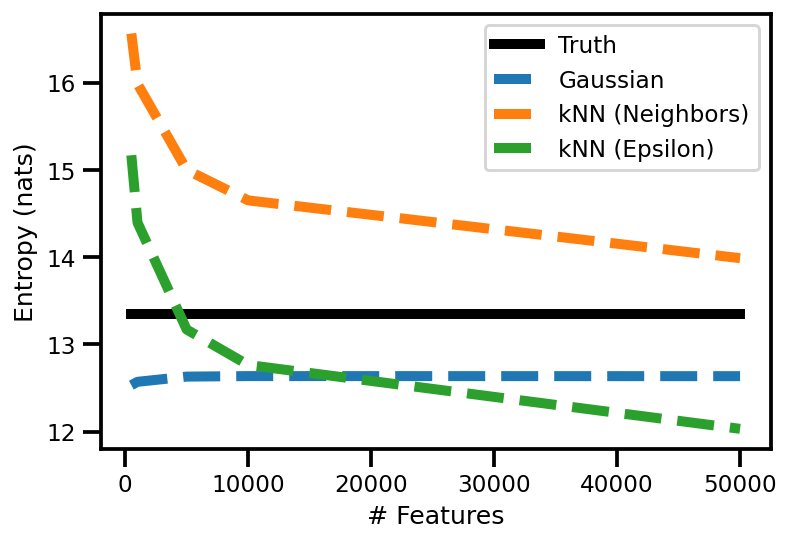

In [51]:
fig, ax = plt.subplots()

stats_ds.sel(n_features=10, algorithm="truth").mean(["trial"]).H.plot(
    ax=ax, label="Truth", linewidth=5, color="black"
)
stats_ds.sel(n_features=10, algorithm="gaussian").mean(["trial"]).H.plot(
    ax=ax, label="Gaussian", linewidth=5, linestyle="--"
)
stats_ds.sel(n_features=10, algorithm="knn_nbs").mean(["trial"]).H.plot(
    ax=ax, label="kNN (Neighbors)", linewidth=5, linestyle="--"
)
# stats_ds.sel(n_features=10, algorithm="knn_tree").mean(["trial"]).H.plot(
#     ax=ax, label="kNN (Epsilon)", linewidth=5, linestyle="--"
# )
t = stats_ds.sel(n_features=10, algorithm="knn_tree").mean(["trial"]).H
# t = t / np.log(2)
t.plot(ax=ax, label="kNN (Epsilon)", linewidth=5, linestyle="--")

ax.set(xlabel="# Features", ylabel="Entropy (nats)", title="")
ax.legend()
plt.show()

### Compare True Values

In [52]:
def percent_error(real, pred):
    pred = np.abs(np.abs(pred - real) / real)
    return pred

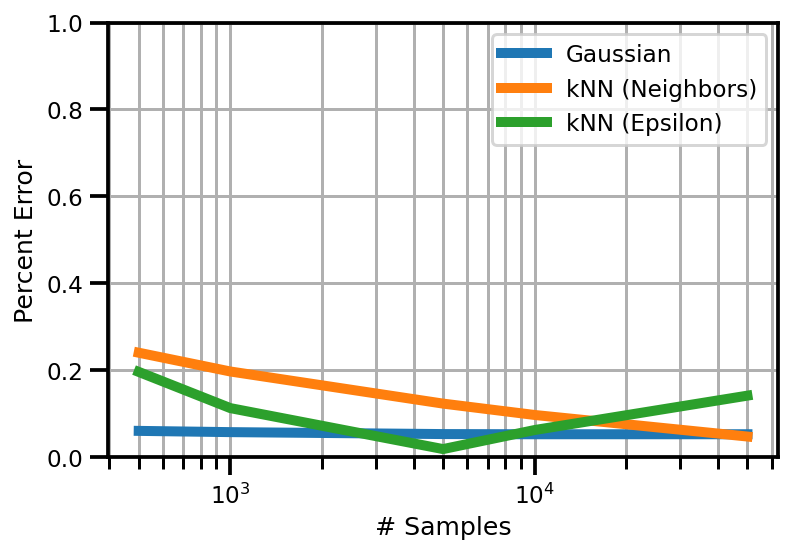

In [53]:
fig, ax = plt.subplots()

real = stats_ds.sel(n_features=10, algorithm="truth").mean(["trial"]).H

# stats_ds.sel(n_features=10, algorithm="truth_nats").mean(["trial"]).H.plot(
#     ax=ax, label="Truth", linewidth=5, color="black"
# )

t = percent_error(
    real, stats_ds.sel(n_features=10, algorithm="gaussian").mean(["trial"]).H
)
t.plot(ax=ax, label="Gaussian", linewidth=5, linestyle="-")


t = percent_error(
    real, stats_ds.sel(n_features=10, algorithm="knn_nbs").mean(["trial"]).H
)
t.plot(ax=ax, label="kNN (Neighbors)", linewidth=5, linestyle="-")

t = percent_error(
    real, stats_ds.sel(n_features=10, algorithm="knn_tree").mean(["trial"]).H
)
t = t / np.log(2)
t.plot(ax=ax, label="kNN (Epsilon)", linewidth=5, linestyle="-")


ax.set(
    xlabel="# Samples", ylabel="Percent Error", title="", xscale="log", ylim=[0.0, 1.0]
)
ax.grid(True, which="both")
ax.legend()
plt.show()

In [38]:
all_stats_ = all_stats.copy()